In [55]:
# Dependencies
import warnings
warnings.filterwarnings("ignore")
import argparse
import pickle
import numpy as np
import pandas
import sys
import itertools
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, f1_score
#from Utils import *

# Keras+Tensorflow libraries
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
#from keras.optimizers import Adadelta
from keras.wrappers.scikit_learn import KerasClassifier
#from keras.layers.normalization import BatchNormalization
from keras import callbacks


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sklearn.decomposition

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, f1_score

In [65]:
df1 = pd.read_csv('CRISPR_gene_dependency.csv', index_col='DepMap_ID')
df2 = pd.read_csv('CRISPR_gene_effect.csv', index_col='DepMap_ID')
#df2 = pd.read_csv('Achilles_gene_effect.csv', index_col=0)
df3 = pd.read_csv('CCLE_expression.csv', index_col=0)
info = pd.read_csv('sample_info_new.csv', index_col='DepMap_ID')

In [66]:
def get_indexes_info(cancer_type):
    indexes = info['primary_disease'].str.match(cancer_type)
    indexes = list(indexes.index[list(np.where(indexes)[0])])
    return indexes

def balance_data(df):
    df_pos = df.loc[df['label']]
    df_neg = df.loc[~df['label']]
    
    n_pos = len(df_pos)
    n_neg = len(df_neg)
    n_bal = min(n_pos, n_neg)
    
    df_pos = df_pos.iloc[np.random.choice(range(n_pos), n_bal)]
    df_neg = df_neg.iloc[np.random.choice(range(n_neg), n_bal)]
    
    return pd.concat([df_pos, df_neg])

def get_X(data_type, cancer_type):
    if data_type == 'dependency':
        df = df1
    elif data_type == 'effect':
        df = df2
    elif data_type == 'expression':
        df = df3
        
    indexes = get_indexes_info(cancer_type)
    negative_set = get_indexes_info('Non-Cancerous')
    df = df.loc[df.index.isin(indexes) | df.index.isin(negative_set)]
    df.insert(0, 'label', df.index.isin(indexes))
    df = balance_data(df)
    
    return df


In [86]:
def get_model_results(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    return [accuracy, precision, recall]

def trainLRmodel(X, Y):
    # Get the training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

    # Fit the model
    model = LogisticRegression().fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_rt = model.predict_proba(X_test)[:, 1]

    return get_model_results(y_test, y_pred)

def trainSVMmodel(X, Y):
    # Get the training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

    # CV
    grid_search_cv = GridSearchCV(
        estimator = SVC(
            probability = True
        ),
        param_grid = [{'kernel':['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                      {'kernel':['linear'], 'C': [1, 10, 100, 1000]} ],
        scoring = "accuracy",
        cv = StratifiedKFold(
            n_splits=5,
            shuffle=True
        ),
        n_jobs = -1, 
        verbose = 1,
        refit = True
    )

    # Fit the model
    model = grid_search_cv.fit(X_train, y_train)

    y_pred = model.best_estimator_.predict(X_test)
    y_pred_rt = model.best_estimator_.predict_proba(X_test)[:, 1]

    return get_model_results(y_test, y_pred)





expression
Fitting 5 folds for each of 12 candidates, totalling 60 fits
		Lung Cancer [1.0, 1.0, 1.0]
0 0


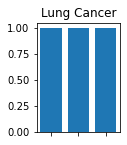

Fitting 5 folds for each of 12 candidates, totalling 60 fits
		Leukemia [1.0, 1.0, 1.0]
0 0


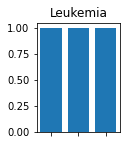

Fitting 5 folds for each of 12 candidates, totalling 60 fits
		Skin Cancer [1.0, 1.0, 1.0]
0 0


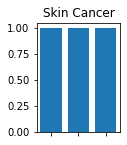

Fitting 5 folds for each of 12 candidates, totalling 60 fits
		Lymphoma [1.0, 1.0, 1.0]
0 0


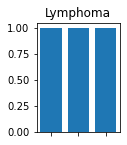

Fitting 5 folds for each of 12 candidates, totalling 60 fits
		Brain Cancer [1.0, 1.0, 1.0]
0 0


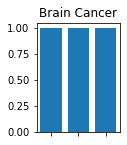

Fitting 5 folds for each of 12 candidates, totalling 60 fits
		Colon/Colorectal Cancer [1.0, 1.0, 1.0]
0 0


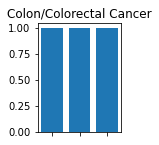

Fitting 5 folds for each of 12 candidates, totalling 60 fits
		Breast Cancer [0.967741935483871, 1.0, 0.9473684210526315]
0 0


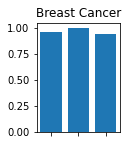

Fitting 5 folds for each of 12 candidates, totalling 60 fits
		Head and Neck Cancer [1.0, 1.0, 1.0]
0 0


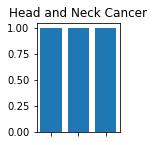

Fitting 5 folds for each of 12 candidates, totalling 60 fits
		Ovarian Cancer [1.0, 1.0, 1.0]
0 0


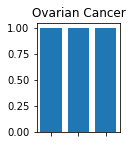

Fitting 5 folds for each of 12 candidates, totalling 60 fits
		Pancreatic Cancer [1.0, 1.0, 1.0]
0 0


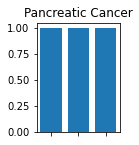

In [119]:
print_result = lambda x: print("\t\t{} {}".format(x[0], x[1]))

for data_type in ['expression']:
    #fig, ax = plt.subplots(2, 5, figsize=(10, 5))
    #fig.tight_layout()

    print(data_type)
    i = 0
    for cancer_type in info['primary_disease'].value_counts().index:
        data = get_X(data_type, cancer_type)
        if len(data) > 100:
            X = data.iloc[:, 1:]
            y = data.iloc[:, 0]
            #print_result(trainRFmodel(X, y))
            #print_result(trainLRmodel(X, y))
            res = trainSVMmodel(X, y)
            print_result([cancer_type, res])
            print(int(np.floor(i/5)), i%5)
            plt.figure(figsize=(1.5,2))
            plt.title(cancer_type)
            plt.bar(['accuracy', 'precision', 'recall'], res, tick_label=['', '', ''])
            fig.tight_layout()
            plt.savefig(cancer_type.replace('/', '_')+'hist', dpi=200, bbox_inches='tight')
            plt.show()

In [33]:
display(df1)
display(df2)
display(df3)
display(info)

,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000001,0.094568,0.012519,0.027460,0.025962,0.073412,0.027340,0.020199,0.284733,0.022084,0.011779,...,0.037449,0.080585,0.034309,0.007142,0.004241,0.082956,0.012000,0.003592,0.012679,0.324623
ACH-000004,0.012676,0.049011,0.075933,0.033215,0.013176,0.097497,0.005015,0.153166,0.007358,0.006057,...,0.038768,0.230569,0.007125,0.021209,0.011203,0.060266,0.128375,0.005911,0.004645,0.042530
ACH-000005,0.053957,0.027968,0.010139,0.005448,0.018599,0.081636,0.005457,0.159904,0.050884,0.033534,...,0.017479,0.274568,0.054525,0.033396,0.033416,0.034712,0.092832,0.012482,0.020843,0.050412
ACH-000007,0.026704,0.083588,0.008853,0.011299,0.027288,0.028349,0.032573,0.166503,0.047045,0.004214,...,0.196233,0.615338,0.011212,0.002200,0.005432,0.035241,0.138445,0.103161,0.146222,0.274833
ACH-000009,0.059383,0.051826,0.015370,0.011721,0.030062,0.078373,0.042128,0.184783,0.032335,0.035345,...,0.152385,0.405712,0.029011,0.002816,0.056461,0.189550,0.328064,0.035161,0.058402,0.269194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002834,0.012720,0.083840,0.013308,0.013315,0.107286,0.079063,0.013340,0.717478,0.040061,0.013598,...,0.027170,0.636352,0.022403,0.052849,0.029567,0.029711,0.024132,0.174946,0.091510,0.421153
ACH-002847,0.058547,0.079576,0.036707,0.030234,0.069976,0.032828,0.012784,0.476383,0.096910,0.031549,...,0.476423,0.967625,0.014249,0.018715,0.010776,0.072452,0.131375,0.115486,0.094022,0.438092
ACH-002874,0.169875,0.017430,0.017965,0.008615,0.117915,0.075693,0.087961,0.144152,0.140377,0.030566,...,0.710398,0.747477,0.045149,0.044243,0.017923,0.077515,0.094231,0.166188,0.058117,0.302708


,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000001,-0.134808,0.059764,-0.008665,-0.003572,-0.106211,-0.008257,0.018711,-0.291985,0.010921,0.064932,...,-0.037619,-0.116524,-0.029331,0.105940,0.147605,-0.119822,0.063387,0.160857,0.058648,-0.316792
ACH-000004,0.081853,-0.056401,-0.106738,-0.014499,0.078209,-0.137562,0.168657,-0.198560,0.133372,0.151300,...,-0.030901,-0.262220,0.136406,0.031327,0.093763,-0.079692,-0.173709,0.153632,0.175627,-0.040869
ACH-000005,-0.094196,-0.014598,0.100426,0.169103,0.032363,-0.148050,0.168931,-0.244777,-0.086871,-0.036037,...,0.039434,-0.336925,-0.095528,-0.035541,-0.035612,-0.040183,-0.165464,0.077343,0.019387,-0.085687
ACH-000007,-0.011544,-0.123189,0.080692,0.061046,-0.013454,-0.016922,-0.029474,-0.206516,-0.063998,0.139288,...,-0.229303,-0.463191,0.061641,0.190301,0.119388,-0.036695,-0.182449,-0.146936,-0.189451,-0.281167
ACH-000009,-0.050782,-0.037466,0.068885,0.090375,0.012634,-0.079339,-0.017808,-0.183192,0.006227,-0.001700,...,-0.157219,-0.318765,0.015761,0.196949,-0.045874,-0.186805,-0.275629,-0.001227,-0.049140,-0.240582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002834,0.093856,-0.141460,0.088443,0.088377,-0.175830,-0.133436,0.088166,-0.681595,-0.045118,0.085937,...,0.002824,-0.588608,0.026231,-0.080376,-0.007511,-0.008117,0.017214,-0.249746,-0.153472,-0.426827
ACH-002847,-0.041373,-0.074384,0.005141,0.023614,-0.060251,0.015849,0.103120,-0.365970,-0.096872,0.019676,...,-0.365993,-1.057614,0.093102,0.068145,0.119134,-0.064060,-0.134209,-0.117938,-0.093320,-0.343878
ACH-002874,-0.141663,0.087888,0.084764,0.175138,-0.097428,-0.050125,-0.065607,-0.121013,-0.117815,0.035131,...,-0.465202,-0.492154,-0.000445,0.001417,0.085010,-0.052544,-0.072800,-0.138826,-0.024263,-0.228572


,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),...,H3C2 (8358),H3C3 (8352),AC098582.1 (8916),DUS4L-BCAP29 (115253422),C8orf44-SGK3 (100533105),ELOA3B (728929),NPBWR1 (2831),ELOA3D (100506888),ELOA3 (162699),CDR1 (1038)
ACH-001113,4.331992,0.000000,7.364397,2.792855,4.470537,0.028569,1.226509,3.042644,6.499686,4.739848,...,2.689299,0.189034,0.201634,2.130931,0.555816,0.000000,0.275007,0.0,0.000000,0.000000
ACH-001289,4.566815,0.584963,7.106537,2.543496,3.504620,0.000000,0.189034,3.813525,4.221104,3.481557,...,1.286881,1.049631,0.321928,1.464668,0.632268,0.000000,0.014355,0.0,0.000000,0.000000
ACH-001339,3.150560,0.000000,7.379032,2.333424,4.227279,0.056584,1.310340,6.687061,3.682573,3.273516,...,0.594549,1.097611,0.831877,2.946731,0.475085,0.000000,0.084064,0.0,0.000000,0.042644
ACH-001538,5.085340,0.000000,7.154109,2.545968,3.084064,0.000000,5.868143,6.165309,4.489928,3.956986,...,0.214125,0.632268,0.298658,1.641546,0.443607,0.000000,0.028569,0.0,0.000000,0.000000
ACH-000242,6.729145,0.000000,6.537607,2.456806,3.867896,0.799087,7.208381,5.569856,7.127014,4.568032,...,1.117695,2.358959,0.084064,1.910733,0.000000,0.000000,0.464668,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000285,0.056584,0.000000,6.604071,3.264536,4.972693,0.411426,0.097611,0.704872,4.829850,5.178715,...,2.229588,0.084064,1.310340,3.039138,0.344828,0.000000,0.000000,0.0,0.475085,0.042644
ACH-002669,3.109361,0.000000,7.031219,1.541019,3.664483,0.014355,3.624101,6.805292,4.472488,4.397118,...,0.189034,0.400538,0.356144,1.327687,0.000000,0.000000,0.014355,0.0,0.000000,0.000000
ACH-001858,4.390943,0.000000,7.013127,1.887525,3.252476,0.028569,3.286881,6.902074,5.410748,3.401903,...,1.097611,0.400538,0.613532,1.992768,0.704872,0.000000,1.464668,0.0,0.000000,0.526069
ACH-001997,5.057017,0.000000,7.814935,2.538538,3.893362,0.028569,4.078951,6.971429,4.469886,3.463361,...,0.831877,0.847997,1.292782,2.153805,0.687061,0.000000,0.000000,0.0,0.000000,0.000000


,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,RRID,WTSI_Master_Cell_ID,sample_collection_site,...,lineage_sub_subtype,lineage_molecular_subtype,default_growth_pattern,model_manipulation,model_manipulation_details,patient_id,parent_depmap_id,Cellosaurus_NCIt_disease,Cellosaurus_NCIt_id,Cellosaurus_issues
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000016,SLR 21,SLR21,SLR21_KIDNEY,NaN,NaN,NaN,Academic lab,CVCL_V607,NaN,kidney,...,NaN,NaN,NaN,NaN,NaN,PT-JnARLB,NaN,Clear cell renal cell carcinoma,C4033,NaN
ACH-000032,MHH-CALL-3,MHHCALL3,MHHCALL3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Female,DSMZ,CVCL_0089,NaN,bone_marrow,...,b_cell,NaN,NaN,NaN,NaN,PT-p2KOyI,NaN,Childhood B acute lymphoblastic leukemia,C9140,NaN
ACH-000033,NCI-H1819,NCIH1819,NCIH1819_LUNG,NaN,NaN,Female,Academic lab,CVCL_1497,NaN,lymph_node,...,NSCLC_adenocarcinoma,NaN,NaN,NaN,NaN,PT-9p1WQv,NaN,Lung adenocarcinoma,C3512,NaN
ACH-000043,Hs 895.T,HS895T,HS895T_FIBROBLAST,NaN,NaN,Female,ATCC,CVCL_0993,NaN,fibroblast,...,NaN,NaN,2D: adherent,NaN,NaN,PT-rTUVZQ,NaN,Melanoma,C3224,NaN
ACH-000049,HEK TE,HEKTE,HEKTE_KIDNEY,NaN,NaN,NaN,Academic lab,CVCL_WS59,NaN,kidney,...,NaN,NaN,NaN,immortalized,NaN,PT-qWYYgr,NaN,NaN,NaN,No information is available about this cell li...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002393,CRO-AP3,CROAP3,CROAP3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Male,Sanger,CVCL_1810,NaN,ascites,...,b_cell_primary_effusion,NaN,NaN,NaN,NaN,PT-TC0lZM,NaN,Primary effusion lymphoma,C6915,NaN
ACH-002394,GEO,GEO,GEO_LARGE_INTESTINE,NaN,NaN,NaN,Sanger,CVCL_0271,NaN,large_intestine,...,NaN,NaN,NaN,NaN,NaN,PT-Fa1q9q,NaN,Colon carcinoma,C4910,NaN
ACH-002395,HuH-6 Clone 5,HUH6CLONE5,HUH6CLONE5_LIVER,NaN,NaN,Male,Sanger,CVCL_1296,NaN,liver,...,NaN,NaN,NaN,NaN,NaN,PT-TtIXsL,ACH-000671,Hepatoblastoma,C3728,NaN


In [22]:
df1 = df1.median(axis=1)
df2 = df2.median(axis=1)
df3 = df3.median(axis=1)

In [23]:
df = pd.merge(df1.rename('dependency'), df2.rename('effect'), left_index=True, right_index=True)
df = pd.merge(df3.rename('expression'), df, left_index=True, right_index=True)

In [24]:
regex = "(\S+) \([0-9]+\)"

def func(x):
    pattern = re.findall(regex, x)
    if len(pattern) > 0:
        return pattern[0]
    else:
        print(x)
        return x

df.index = df.index.to_series().apply(func)

In [7]:
display(df)

,expression,dependency,effect
TSPAN6,3.628104,0.012735,0.095423
TNMD,0.000000,0.024042,0.014524
DPM1,6.376012,0.305808,-0.303232
SCYL3,2.024920,0.063092,-0.076960
C1orf112,3.402198,0.026304,0.021511
...,...,...,...
CCDC39,0.480182,0.029122,0.008332
H3C2,0.650765,0.062155,-0.084694
H3C3,0.516015,0.131142,-0.161056
NPBWR1,0.117680,0.036591,-0.044818


In [8]:
#labels = pd.read_csv('labels.csv', index_col='gene').iloc[:, 1]
labels = pd.read_csv("cancer_kidney_training.txt", index_col='gene')#.iloc[:, 1]
labels.rename_axis("DepMap_ID")
labels = labels == 'positive'
display(labels)

,label
gene,
PLK4,True
CTLA4,True
FLT3,True
LCK,True
FLT1,True
...,...
EFNA3,False
HIST1H4L,False
CRYGS,False


In [9]:
merge = df.merge(labels, how='inner', left_index=True, right_index=True)
display(merge)

,expression,dependency,effect,label
HSPB6,0.286881,0.028060,-0.001315,False
LUC7L,4.969485,0.030977,-0.004147,False
FMO3,0.000000,0.037226,-0.031257,False
GPRC5A,4.621938,0.037947,-0.032314,False
FLT4,0.070389,0.031968,0.002805,True
...,...,...,...,...
SHISA9,2.543392,0.016796,0.071028,False
SPATS1,0.000000,0.114800,-0.146937,False
PCDHGA8,0.137504,0.033097,-0.023109,False
GDF2,0.000000,0.048419,-0.026499,False


In [10]:
merge['label'].value_counts()

False    178
True      31
Name: label, dtype: int64

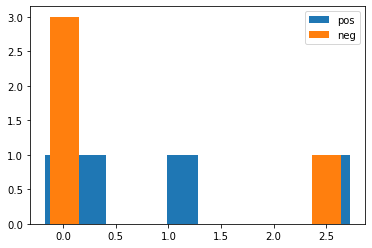

In [11]:
plt.hist(merge.loc[merge['label']].mean(axis=0), label='pos')
plt.hist(merge.loc[~merge['label']].mean(axis=0), label='neg')
plt.legend()
plt.show()

In [12]:
merge = merge.dropna(axis='index')
data = merge.iloc[:, :-1]
y = merge.iloc[:, -1]
display(data)
display(y)

,expression,dependency,effect
HSPB6,0.286881,0.028060,-0.001315
LUC7L,4.969485,0.030977,-0.004147
FMO3,0.000000,0.037226,-0.031257
GPRC5A,4.621938,0.037947,-0.032314
FLT4,0.070389,0.031968,0.002805
...,...,...,...
SHISA9,2.543392,0.016796,0.071028
SPATS1,0.000000,0.114800,-0.146937
PCDHGA8,0.137504,0.033097,-0.023109
GDF2,0.000000,0.048419,-0.026499


HSPB6      False
LUC7L      False
FMO3       False
GPRC5A     False
FLT4        True
           ...  
SHISA9     False
SPATS1     False
PCDHGA8    False
GDF2       False
RCC1L      False
Name: label, Length: 209, dtype: bool

In [13]:
#pca = sklearn.decomposition.PCA(n_components=32, whiten=True)
X = data# = pca.fit_transform(data)
#print(pca.explained_variance_ratio_)

In [14]:
select = np.maximum(y, np.random.rand(len(y)) < sum(y)/(len(y) - sum(y)))
X = X[select]
y = y[select]
print(X.shape)
print(y.shape)
print(sum(y))
#sns.scatterplot(X[:,0], X[:,1], hue=y)
#plt.show()

(63, 3)
(63,)
31


In [15]:
# Get the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Fit the model
model = LogisticRegression().fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_rt = model.predict_proba(X_test)[:, 1]

accuracy = str(accuracy_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rt)
auc_value = str(auc(fpr, tpr))
precision = str(precision_score(y_test, y_pred))
recall = str(recall_score(y_test, y_pred))
f1score = str(f1_score(y_test, y_pred, average="weighted"))

0.3157894736842105
0.3333333333333333
0.4444444444444444


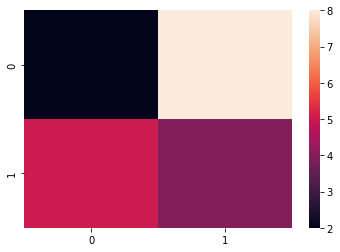

[[2 8]
 [5 4]]


In [16]:
print(accuracy)
print(precision)
print(recall)

conf_mx = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mx)
plt.show()

print(conf_mx)

In [17]:
print(sum(y_test), sum(y_pred))

9 12


In [19]:
display(info['lineage'])

DepMap_ID
ACH-000016        kidney
ACH-000032         blood
ACH-000033          lung
ACH-000043    fibroblast
ACH-000049        kidney
                 ...    
ACH-002393    lymphocyte
ACH-002394    colorectal
ACH-002395         liver
ACH-002396          bone
ACH-002397       thyroid
Name: lineage, Length: 1840, dtype: object